# Lab 9d: Does _Klebsiella oxytoca_ have free will?
This lab will familiarize students with solving linear resource allocation problems using [linear programming](https://en.wikipedia.org/wiki/Linear_programming). The example problem explored in this lab is the carbon choice problem modeled by [Kompala et al. 1986](paper/Kompala-BiotechBioengineering-1986.pdf). 
* Understanding how bacterial cells choose between different sugars, such as glucose, is a crucial area of study in biology. This decision-making process also observed in [other organisms like yeast](https://pubmed.ncbi.nlm.nih.gov/9381177/), is encoded at a molecular level using [carbon catabolite repression pathways](https://pubmed.ncbi.nlm.nih.gov/18628769/).

### Hypothesis
Suppose we hypothesize that cells are rational consumers, and they are maximizing a linear utility function subject to a budget constraint by carefully choosing which enzyme(s) $e_{i}$ (decision variables) to construct (enzymes are expensive to synthesize) subject to limited cellular resources:
$$
\begin{eqnarray*}
\text{maximize}~U(e_{1},\dotsc,e_{n}) & = & \sum_{i\in\mathcal{S}}\gamma_{i}\cdot{e}_{i}(R) \\
\text{subject to}~\sum_{i\in\mathcal{S}}\hat{b}_{i}\cdot{e}_{i}(R) & = & 1 \\
\text{and}~e_{i}&\geq&{0}\qquad{i=1,2,\dots,n}
\end{eqnarray*}
$$
where $\gamma_{i}$ (the unit benefit from making $e_{i}$) is defined as:
$$
\begin{equation}
\gamma_{i} \equiv \left(\frac{\mu^{max}_{i}s_{i}c}{K_{i}+s_{i}}\right)
\end{equation}
$$
and $\hat{b}_{i}$ (the scaled unit cost of manufacturing $e_{i}$) is approximated by:
$$
\begin{equation}
\hat{b}_{i}^{-1} \approx \frac{1}{\delta_{i}}\cdot{\left(\frac{1}{\tau_{i}}+\lambda_{i}\right)}
\end{equation}
$$
where $\delta_{i} \equiv \left(\mu_{g}^{max} + k_{d}^{(i)}\right)$. 

#### Parameters
* The $\mu^{\text{max}}_{i}$ parameter denotes the maximum specific growth rate of cells on sugar $i$,
$s_{i}$ denotes the concentration of sugar $i$,  $K_{i}$ denotes the growth saturation constant for sugar $i$, and $c$ denotes the concentration of cells.
* The parameter $\tau_{i}$ denotes the characteristic time constant for the expression of pseudo enzyme $i$,
and $\lambda_{i}$ denotes the unregulated pseudo enzyme $i$ synthesis rate.
The $\mu^{max}_{i}$ parameter denotes the maximum specific growth rate of the cells on sugar $i$,
and $k^{i}_{d}$ denotes the degradation rate constant for pseudo enzyme $i$.
* Finally, $k_{d}^{c}$ denotes the degradation rate constant for cells (units: 1/h), 
and the yield coefficient $Y_{i}$ denotes the amount of sugar $i$ consumed per unit of biomass produced.


__Super cool feature__: We can compute the values of $\gamma_{i}$ and $\hat{b}_{i}$ from the problem parameters; thus, we can compute these for each sugar combination and see what enzymes are expressed!

## Setup
We set up the computational environment by including [the `Include. jl` file](Include.jl) using [the `include(...)` method](https://docs.julialang.org/en/v1/base/base/#Base.include). The [`Include.jl` file](Include.jl) loads external packages and functions we will use in these examples. 
* For additional information on functions and types used in this example, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/). 

In [3]:
include("Include.jl");

## Prerequisites
To compute the values for coefficients $(\gamma_{i},\hat{b}_{i})$, we need to load the parameters from the [Kompala et al. study](paper/Kompala-BiotechBioengineering-1986.pdf) using the `loadparameters()` function which loads the [Parameters.toml file](conf/Parameters.toml). Then, we compute the problem coefficients $(\gamma_{i},\hat{b}_{i})$, and we store these values in the `γ` and `b̂` variables.

In [5]:
parameters = loadparameters();

In [6]:
parameters

Dict{String, Any} with 5 entries:
  "lactose"   => Dict{String, Any}("death_rate_constant"=>"0.026", "saturation_…
  "glucose"   => Dict{String, Any}("death_rate_constant"=>"0.029", "saturation_…
  "fructose"  => Dict{String, Any}("death_rate_constant"=>"0.025", "saturation_…
  "xylose"    => Dict{String, Any}("death_rate_constant"=>"0.022", "saturation_…
  "arabinose" => Dict{String, Any}("death_rate_constant"=>"0.027", "saturation_…

In [7]:
list_of_sugars = keys(parameters) |> collect |> sort
number_of_sugars = length(list_of_sugars);

In [8]:
list_of_sugars

5-element Vector{String}:
 "arabinose"
 "fructose"
 "glucose"
 "lactose"
 "xylose"

### Compute the $\hat{b}_{i}$ values for each sugar in our collection
The $\hat{b}_{i}$ values are the scaled cost coefficients that appear in the resource constraint equation. We compute the expression cost coefficients $\hat{b}_{i}$ using a steady-state approximation:
$$
\begin{equation}
\hat{b}_{i}^{-1} \approx \frac{1}{\delta_{i}}\cdot{\left(\frac{1}{\tau_{i}}+\lambda_{i}\right)}
\end{equation}
$$
where we made use of the property that the cybernetic control variable $u_{i} \rightarrow 1$ in this condition,  and defined $\delta_{i} \equiv \left(\mu_{g}^{max} + k_{d}^{(i)}\right)$. The $\lambda_{i}$ denotes the rate or non-regulated gene expression for enzyme $e_{i}$.

In [10]:
b̂ = zeros(number_of_sugars);
for i ∈ eachindex(list_of_sugars)
    sugar = list_of_sugars[i];
    p = parameters[sugar];

    λᵢ = p["lambda"] |> x-> parse(Float64,x);
    kᵢ = p["beta"] |> x-> parse(Float64,x);
    μᵢ = p["specific_growth_rate"] |> x-> parse(Float64,x);
    τᵢ = p["tau"] |> x-> parse(Float64,x);
    δᵢ = (μᵢ + kᵢ);
    b̂[i] = ((1/δᵢ)*(1/τᵢ + λᵢ))^-1;
end

In [11]:
b̂

5-element Vector{Float64}:
 0.6537356321839081
 0.5637319316688568
 0.7035440613026821
 0.6226053639846744
 0.24125426621160412

In [12]:
bounds_enzyme_values = zeros(number_of_sugars,2);
for i ∈ 1:number_of_sugars
    bounds_enzyme_values[i,1] = 0.0
    bounds_enzyme_values[i,2] = 1/b̂[i]
end

### Compute the $\gamma_{i}$ values for each sugar in our collection
We can compute the $\gamma_{i}$ coefficients from data in the paper.

In [14]:
Sₒ = [
    2.0  ; # 1 arabinose
    4.0  ; # 2 fructose
    0.33 ; # 3 glucose
    1.5  ; # 4 lactose
    2.0  ; # 5 xylose
];

In [15]:
cₒ = 0.005; # units: gDW/L
γ = zeros(number_of_sugars)
for i ∈ eachindex(list_of_sugars)
    sugar = list_of_sugars[i];
    p = parameters[sugar];

    emax = p["emax"] |> x-> parse(Float64,x);
    Kᵢ = p["saturation_constant"] |> x-> parse(Float64,x);
    μᵢ = p["specific_growth_rate"] |> x-> parse(Float64,x);
    sᵢ = Sₒ[i];
    γ[i] = ((μᵢ/emax)*sᵢ*cₒ)/(Kᵢ+sᵢ);
end

In [16]:
γ

5-element Vector{Float64}:
 0.0031889543033361374
 0.0028897583627139054
 0.003687398580121705
 0.0007393438697318008
 0.0020189393939393937

## Task 1: Predict binary choice behavior for sugar combinations (primal problem)
Let's pose the choice behavior of _Klebsiella oxytoca_ as a [linear programming problem](https://en.wikipedia.org/wiki/Linear_programming). Don't worry so much about how a linear programming solver works (we are invoking the `buy` side of `buy` versus `build` for the moment). Instead, we'll try to understand the problem and dig into the details later. 

Here's how we compute the optimal value for a constrained `linear` utility maximization problem: 
* First, we select two sugars from our collection of sugars: `arabinose, fructose, glucose, lactose, and xylose.`
* Next, we create an instance of [the `MySimpleLinearChoiceProblem` type](src/Types.jl) using [the `build(...)` method](src/Factory.jl). We input problem parameters, such as the utility function coefficients, cost values, total budget values, an initial guess, and allocation bounds.
* Then, we use [the `solve(...)` method](src/Solve.jl) with the `problem` instance and store the solution in the `solution` variable:

In [18]:
my_test_sugars = ["glucose", "xylose"]; # which sugars to do we want?

Create an instance of [the `MySimpleLinearChoiceProblem` type](src/Types.jl) using [the `build(...)` method](src/Factory.jl). Pass the problem parameters, such as the utility function coefficients, cost values, total budget values, an initial guess, and allocation bounds to the `build(...)` function:

In [20]:
(problem, idx_test_sugars) = let

    idx_test_sugars = Array{Int64,1}();
    for i ∈ eachindex(my_test_sugars)
        sugar = my_test_sugars[i];
        idx = findfirst(x-> x==sugar, list_of_sugars);
        push!(idx_test_sugars,idx)
    end

    problem = build(MySimpleLinearChoiceProblem, (
        α = γ[idx_test_sugars], # coeff in obj vector (marginal utility)
        c = b̂[idx_test_sugars], # unit costs
        I = 1.0, # resource bound right-hand side
        bounds = bounds_enzyme_values[idx_test_sugars,:],
        initial = [0.1, 0.1]  
    ));

    (problem, idx_test_sugars)
end;

Use [the `solve(...)` method](src/Solver.jl) with the `problem::MySimpleLinearChoiceProblem` instance to solve the linear programming problem, and store the solution in the `soln` variable (which is a dictionary holding the solution and some other data):

In [22]:
primal_solution = nothing;
try 
    primal_solution = solve(problem)
catch error
    println(error)
end

Dict{String, Any} with 3 entries:
  "argmax"          => [0.0, 4.145]
  "budget"          => 1.0
  "objective_value" => 0.00836851

We can access the values stored in the `soln` dictionary by passing in the `key`:

In [24]:
obj_value = primal_solution["objective_value"]

0.008368512713340298

In [25]:
test_soln = primal_solution["argmax"] # this is the steady-solution of the enzyme level

2-element Vector{Float64}:
 0.0
 4.145004420866489

### Check: Do we recover the optimum value of the objective function?
Let's use the [@assert macro](https://docs.julialang.org/en/v1/base/base/#Base.@assert) to check if the objective function value returned by the solver and the value of the objective function computed using the optimal solution is `close.` If this test fails, [an AssertionError](https://docs.julialang.org/en/v1/base/base/#Core.AssertionError) is thrown.

In [27]:
𝒪_computed = test_soln[1]*γ[idx_test_sugars[1]]+test_soln[2]*γ[idx_test_sugars[2]];
@assert isapprox(𝒪_computed, primal_solution["objective_value"],atol=1e-6)

### Visualize the optimal solution, the budget line, and the indifference curves
`Unhide` the code blocks below to see how we plot the `budget line,` the `solution` point, and the `indifference curves.` First, let's compute the budget line and store this in the `budget_line::Array{Float64,2}` variable:

In [29]:
budget_line = let
    ϵ = 0.01;
    number_of_steps = Int(floor((1.0 - 0.0)/ϵ));
    budget_line = zeros(number_of_steps+1,2);
    for i = 1:(number_of_steps+1)
        θ = ϵ*(i-1)
        budget_line[i,1] = θ*(1/b̂[idx_test_sugars[1]])
        budget_line[i,2] = (1-θ)*(1/b̂[idx_test_sugars[2]])
    end
    budget_line;
end;

Next, let's compute the indifference curves and plot the indifference curves and the budget line on the enzyme sugar `1` versus enzyme sugar `2` plane.

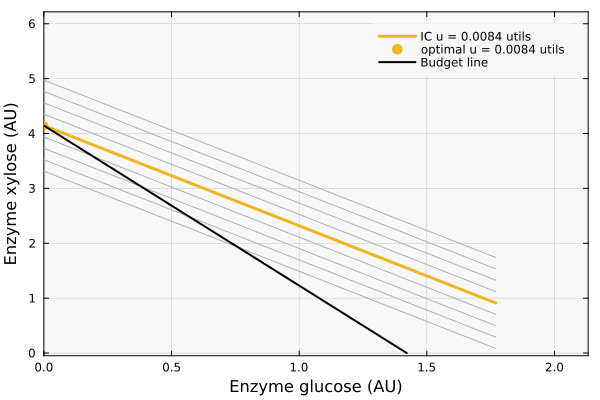

In [31]:
let

    model = build(VLLinearUtilityFunction, (
        α = γ[idx_test_sugars],
    ));

    
    q = plot();  
    θ_array = range(0.80,stop=1.2,length=9) |> collect;
    for i ∈ eachindex(θ_array)
        θᵢ = θ_array[i];
        indiff_array = indifference(model,  utility = θᵢ*obj_value, 
            bounds = 1.25*bounds_enzyme_values[idx_test_sugars[1],:] , ϵ=0.01)
    
        line_color = :gray69
        lwv = 1
        labeltext = ""
        if (θᵢ == 1.0)
            line_color = :goldenrod2
            lwv = 3
            labeltext="IC u = $(round(θᵢ*obj_value,digits=4)) utils"
        end
        
        plot!(indiff_array[:,1],indiff_array[:,2], xlims=(0.0,1.5*(1/b̂[idx_test_sugars[1]])), 
            ylims=(-0.05,1.5*(1/b̂[idx_test_sugars[2]])), lw=lwv, c=line_color, label=labeltext, 
            bg=:gray97, background_color_outside="white", framestyle = :box, fg_legend = :transparent)
    end
    current()
    scatter!([test_soln[1]],[test_soln[2]], c=:goldenrod2, msc=:goldenrod2, ms=5, label="optimal u = $(round(obj_value,digits=4)) utils")
    plot!(budget_line[:,1],budget_line[:,2],c=:black, lw=2, label="Budget line")
    xlabel!("Enzyme $(my_test_sugars[1]) (AU)", fontsize=18)
    ylabel!("Enzyme $(my_test_sugars[2]) (AU)", fontsize=18)
end

#### Save figure

In [33]:
savefig(joinpath(_PATH_TO_FIGS, "Fig-$(my_test_sugars[1])-$(my_test_sugars[2])-IC-Budget-GB-lambda.pdf"))

"/Users/jeffreyvarner/Desktop/julia_work/CHEME-4800-5800-Examples-Fall-2024/discussion/week-9/D9b/figs/Fig-glucose-xylose-IC-Budget-GB-lambda.pdf"

## Task 2: What does the dual problem say?
In this task, we solve the dual linear choice problem and explore how it contrasts with the solution of the primal problem. Let's begin by constructing [a `MyLinearProgrammingDualProblemModel` instance](src/Types.jl) using [a `build(...)` method](src/Factory.jl) and then pass this problem instance to [the `solve(...)` method](src/Solve.jl).

In [35]:
dual_problem = let

    # setup bounds
    bounds = [0 1000];

    # stupid Julia type thing
    A = reshape(b̂[idx_test_sugars], (1,2))

    # build the dual problem model     
    dual_problem = build(MyLinearProgrammingDualProblemModel, (
        c = [1.0], # dual problem: right-hand side of the primal constraints
        b = γ[idx_test_sugars], # dual problem: obj coeff in the primal problem
        A = transpose(A) |> Matrix, # dual problem: constraint are transposed
        lb = [0.0], # dual problem lb
        ub = [1000] # dual problem ub
    ));
end;

Solve the dual problem by passing in the `dual_problem::MyLinearProgrammingDualProblemModel` instance to [the `solve(...)` method](src/Solve.jl). The solution is stored in the `dual_solution::Dict{String, Any}` variable:

In [37]:
dual_solution = nothing;
try
    dual_solution = solve(dual_problem)
catch (error)
    println(error)
end

Dict{String, Any} with 2 entries:
  "argmin"          => [0.00836851]
  "objective_value" => 0.00836851

### Hmmmm. How should we interpret the `dual` solution $y$?
One way to start thinking about the meaning of the dual variable $y$ is to look at its units. From the units of $\gamma$ (units: `gDW/L-hr`), $\hat{b}$ (units: `dimensionless`), and the constraints on the dual problem, we can see that the dual variable $y$ has units: `gDW/L-hr.` Thus, the dual problem is minimizing the expenditure of resource $I\cdot{y}$ (units: `gDW/L-hr`) such that we produce the maximum benefit for the cell (growth).

### Check: Does the `dual` solution say anything about the correct choice?
The `dual` solution does not explicitly calculate the sugar the cell uses (the solution to the `primal` problem). Still, from our interpretation outlined above, it __should__ say something about which sugar we choose. 
* Let's check the relationship $y = \max\left\{\gamma_{1}/\hat{b}_{1},\gamma_{2}/\hat{b}_{2}\right\}$ and see which index is bigger (this should correspond to the largest scaled benefit). Thus, the sugar that is chosen $i^{\star} = \arg\max\left\{\gamma_{1}/\hat{b}_{1},\gamma_{2}/\hat{b}_{2}\right\}$

In [40]:
γ̄ = γ[idx_test_sugars];
b̄ = b̂[idx_test_sugars];
test = [γ̄[1]/b̄[1], γ̄[2]/b̄[2]] |> argmax

2

In [41]:
test = [γ̄[1]/b̄[1], γ̄[2]/b̄[2]]

2-element Vector{Float64}:
 0.005241176470588236
 0.008368512713340298

### Check: Is the weak duality condition met?
Finally, we know from the [weak duality condition](https://en.wikipedia.org/wiki/Weak_duality) that $\mathcal{O}^{\prime}(\mathcal{y}^{\star})\geq\mathcal{O}(\mathcal{x}^{\star})$, where $\mathcal{y}^{\star}$ denotes the optimal solution of the dual problem, and $\mathcal{x}^{\star}$ denotes the optimal solution of the primal problem. 
* Let's check if the equality condition is true using the [@assert macro](https://docs.julialang.org/en/v1/base/base/#Base.@assert). If the Boolean `assertion fails,` then an [AssertionError](https://docs.julialang.org/en/v1/base/base/#Core.AssertionError) is thrown

In [43]:
x = dual_solution["objective_value"]
y = primal_solution["objective_value"]
@assert isapprox(abs(x-y), 0.0, atol=1e-5) 